## Import Depencies and read in the meta data

In [1]:
# Import Dependencies
import pandas as pd
import gradio as gr
import operator as op
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import gradio as gr
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import random

import numpy as np


In [2]:
# Reading the meta file containing all image file names
df = pd.read_csv("Resources/metadata.csv")


0 of 714: Attempting to import Automatic Rifle_10.jpeg
1 of 714: Attempting to import Automatic Rifle_100.jpeg
2 of 714: Attempting to import Automatic Rifle_11.jpeg
3 of 714: Attempting to import Automatic Rifle_12.jpeg
4 of 714: Attempting to import Automatic Rifle_13.jpeg
FAILED: Automatic Rifle_13.jpeg
5 of 714: Attempting to import Automatic Rifle_14.jpeg
6 of 714: Attempting to import Automatic Rifle_15.png
7 of 714: Attempting to import Automatic Rifle_16.png
8 of 714: Attempting to import Automatic Rifle_17.jpeg
9 of 714: Attempting to import Automatic Rifle_18.png
10 of 714: Attempting to import Automatic Rifle_19.jpeg
FAILED: Automatic Rifle_19.jpeg
11 of 714: Attempting to import Automatic Rifle_20.jpeg
12 of 714: Attempting to import Automatic Rifle_21.jpeg
13 of 714: Attempting to import Automatic Rifle_22.jpeg
14 of 714: Attempting to import Automatic Rifle_23.jpeg
15 of 714: Attempting to import Automatic Rifle_24.jpeg
16 of 714: Attempting to import Automatic Rifle_25.j

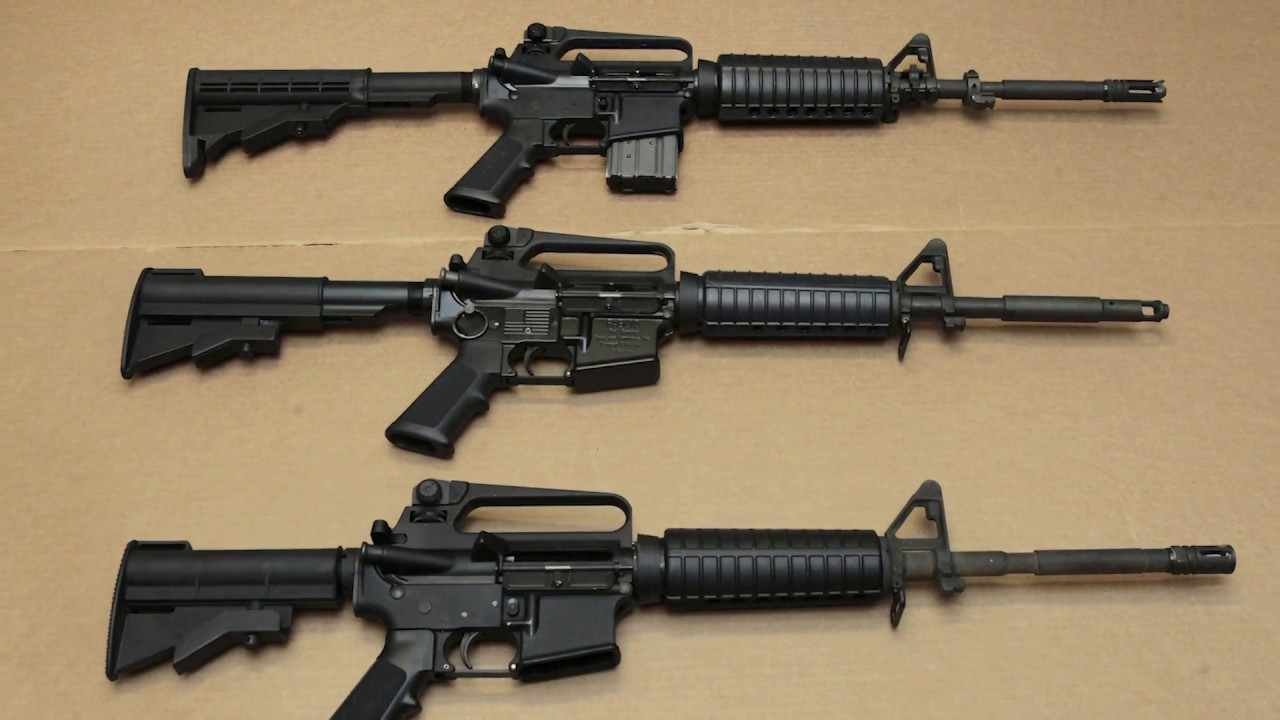

In [3]:
# Build a list of imported images
base_path = "Resources/weapon_detection/train/images/"
images = []
for i in range(len(df)):
    filename = df.iloc[i,0]
    path = base_path + filename
    print(f'{i} of {len(df)}: Attempting to import {filename}')
    try:
        
        images.append(Image.open(path))
    except:
        print(f'FAILED: {filename}')


images[0]

In [4]:

# Print a random image from the list to ensure the import was successful 
# and check the image size
df = df.loc[df['train_id'] != 0]
df.head()

,imagefile,labelfile,target,train_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1
5,Automatic Rifle_14.jpeg,Automatic Rifle_14.txt,0,1


## Pre-process images to prep for splitting into training and testing data

In [5]:
# Check all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{(220, 140),
 (250, 200),
 (260, 280),
 (270, 323),
 (275, 275),
 (283, 879),
 (295, 280),
 (300, 200),
 (315, 681),
 (320, 320),
 (334, 500),
 (348, 210),
 (351, 500),
 (354, 500),
 (355, 239),
 (355, 282),
 (355, 355),
 (364, 280),
 (389, 276),
 (390, 280),
 (400, 400),
 (416, 280),
 (420, 368),
 (425, 425),
 (433, 537),
 (440, 171),
 (440, 440),
 (448, 340),
 (462, 280),
 (463, 1800),
 (480, 360),
 (481, 280),
 (493, 450),
 (498, 500),
 (498, 1024),
 (500, 333),
 (500, 344),
 (500, 350),
 (500, 443),
 (500, 500),
 (509, 330),
 (509, 360),
 (509, 680),
 (512, 512),
 (520, 280),
 (522, 560),
 (526, 340),
 (539, 280),
 (540, 360),
 (547, 280),
 (550, 240),
 (550, 422),
 (560, 400),
 (562, 746),
 (563, 1000),
 (569, 569),
 (585, 370),
 (586, 360),
 (590, 393),
 (600, 256),
 (600, 300),
 (600, 315),
 (600, 338),
 (600, 420),
 (600, 472),
 (600, 600),
 (600, 947),
 (604, 340),
 (616, 353),
 (620, 350),
 (621, 414),
 (626, 352),
 (626, 469),
 (638, 320),
 (640, 360),
 (640, 426),
 (648, 43

In [6]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in images]

# Display the pixel values of the first image
print("Pixel Values:")
print(float_images[0])

In [ ]:
# normalize images to a range between 0 and 1 by
# dividing all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values 
print("Pixel Values:")
print(normalized_images[0])

In [ ]:
# Split .txt and number
df[['weapon', 'weapon_id']] = df['labelfile']\
                                            .str.replace('.txt', '', regex=False)\
                                            .str.split('_', expand=True)
# Drop initial column 
df = df.drop('labelfile',axis=1).set_index(['weapon_id'])

df.head()

In [ ]:
df = df.drop('labelfile',axis=1).set_index(['weapon_id'])
df

In [ ]:
# Set X and y values
X = normalized_images
y = df['target']
# Check value lengths for X and y variables
len(X),len(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Augment to get more samples

In [ ]:
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline
augmentation_model = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),         
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.2),            
    tf.keras.layers.RandomFlip('horizontal')     
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Add a channel dimension for grayscale images
    img = np.expand_dims(img, axis=-1)  # Add channel dimension

    # Ensure that the input data has the correct shape
    #img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(augmentation_model(img, training=True)[0].numpy())
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

In [ ]:
X_train_aug

In [ ]:
y_train_aug

In [ ]:
# function to get unique values from list

def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if op.countOf(unique_list, x) == 0:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

# driver code
list1 = y_train_aug
print("the unique values from 1st list is")
unique(list1)


In [ ]:
# Reshape test data for the model
X_test_reshaped = []
for img in X_test:
    # Add a channel dimension for grayscale images
    img = np.expand_dims(img, axis=-1) 
    # Append the image to the list
    X_test_reshaped.append(img)

# Convert to numpy array
#X_test_reshaped = np.array(X_test_reshaped)

# Check the shape of the first image
X_test_reshaped[0].shape